# Portfolio Optimization - classical solution

## Import

In [17]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit.result import QuasiDistribution
import numpy as np
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf


## Generazione dei dati

In questa sezione, utilizziamo la classe `RandomDataProvider` di Qiskit per generare dati storici casuali relativi a un portafoglio di 8 asset fittizi. 

- **assets:** Numero di azioni nel portafoglio.
- **seed:** Valore per garantire la riproducibilità dei dati.
- **data_provider:** Simula i ritorni medi e la matrice di covarianza per il periodo specificato.

Il vettore `mu` contiene i ritorni medi per ogni asset, mentre la matrice `sigma` rappresenta la covarianza tra i ritorni.

In [ ]:

assets = 4
seed = 2024


start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2024, 1, 1)

stocks = [("TICKER_%s" % i) for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=stocks,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
# print(data_provider._data)

## Stampa dei dati

In [72]:
stock_data = data_provider._data

# devo escludere il giorno di inizio o di fine perché non viene considerato
dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

# print(dates)
print(f"\nDati Generati per il periodo dal {start_date.date()} al {end_date.date()}:")
print("-" * 80)
print(f"{'Data':<12}", end="")
for i in range(len(stock_data)):
    print(f"TICKER_{i:<5}", end="")
print()

for i, date in enumerate(dates):
    # print(i)
    # print(f"{date.date():<12}", end="")
    print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
    
    # print(stock_data[i])
    for j in range(len(stock_data)):
        print(f"{stock_data[j][i]:<12.3f}", end="")
    
    print()
print("-" * 80)


Dati Generati per il periodo dal 2024-01-01 al 2024-01-04:
--------------------------------------------------------------------------------
Data        TICKER_0    TICKER_1    TICKER_2    TICKER_3    
2024-01-01  92.029      78.607      46.509      58.269      
2024-01-02  93.671      78.674      48.319      57.161      
2024-01-03  94.817      79.536      49.070      58.645      
--------------------------------------------------------------------------------


## Visualizzazione del grafico delle azioni

In [ ]:
# TODO
# stock_data = data_provider._data

# dates = pd.date_range(start=start_date, end=end_date, inclusive="left")
# ohlc_data = []

# for i, ticker_data in enumerate(stock_data):
#     print(f"Processing ticker {i} of {len(stock_data)}")
#     print(f"Ticker: {ticker_data}")

#     open_prices = []
#     close_prices = ticker_data
#     high_prices = []
#     low_prices = []
    
#     # numero di scambi giornalieri (casuale perché dati fintizzi)
#     volume = np.random.randint(100, 1000, size=len(ticker_data))

#     for j in range(len(ticker_data)):
#         if j == 0:
#             # generati casualmente dato che è il primo giorno
#             open_prices.append(ticker_data[j])
#             high_prices.append(ticker_data[j] * 1.02)
#             low_prices.append(ticker_data[j] * 0.98)
#         else:
#             # variazione in percentuale
#             # fattore arbitrario per moderare l'effetto della variazione percentuale sui prezzi di massimo e minimo.
#             factor = 0.5
#             change_pct = (ticker_data[j] - ticker_data[j-1]) / ticker_data[j-1]
#             open_prices.append(ticker_data[j-1])
#             high_prices.append(ticker_data[j] * (1 + change_pct * factor))
#             low_prices.append(ticker_data[j] * (1 - change_pct * factor))

#     df = pd.DataFrame({
#         'Date': dates,
#         'Open': open_prices,
#         'High': high_prices,
#         'Low': low_prices,
#         'Close': close_prices,
#         'Volume': volume
#     })
    
#     df.set_index('Date', inplace=True)
#     ohlc_data.append(df)

# n_rows = (assets + 1) // 2
# fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 6 * n_rows))
# axes = axes.flatten()

# for i, ticker in enumerate(stocks):
#     df = ohlc_data[i]
#     print(df.head())
#     # print(df.isnull().sum())
#     mpf.plot(df, ax=axes[i], type='candle', title=f"{ticker} Performance", ylabel="Prezzo")
#     axes[i].grid(True)

# for j in range(assets, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


## Visualizzazione della matrice di covarianza

Questa sezione utilizza Matplotlib per visualizzare la matrice di covarianza (`sigma`).

- Le celle più scure indicano una covarianza maggiore, cioè una correlazione più forte tra i rispettivi asset.

> Questo tipo di visualizzazione aiuta a comprendere il rischio sistematico del portafoglio.

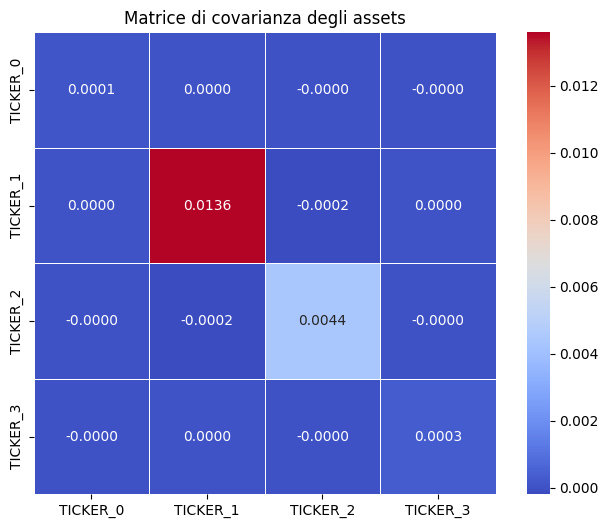

In [ ]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

sigma_df = pd.DataFrame(sigma, index=stocks, columns=stocks)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Matrice di covarianza degli assets")
plt.show()

## Impostazione del problema di ottimizzazione

Configuriamo il problema di ottimizzazione del portafoglio utilizzando la classe `PortfolioOptimization`.

- **risk_factor:** Parametro che bilancia rischio e ritorno nell’ottimizzazione.
- **buget:** Numero massimo di asset selezionabili.

Questo problema viene convertito in un Quadratic Program, che può essere risolto sia con metodi classici che quantistici.

In [ ]:
risk_factor = 0.5
# 50% of the assets
budget = assets // 2

# penalty = assets
po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()
# print(qp)

## Interpretazione dei risultati

Stampiamo e analizziamo i risultati dell'ottimizzazione:

- **Selection:** Array binario che indica quali asset sono stati inclusi nel portafoglio ottimale.
- **Value:** Valore ottimizzato del portafoglio.
- **Probabilities:** Nel caso di solver quantistici, probabilità associate agli autostati.

Questa sezione fornisce un riepilogo dettagliato delle scelte effettuate dal modello.

In [ ]:
def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Risoluzione classica del problema

Utilizziamo un risolutore classico basato su autovalori per trovare la soluzione ottimale del problema.

- **NumPyMinimumEigensolver:** Algoritmo classico che calcola esattamente gli autovalori.
- **MinimumEigenOptimizer:** Wrapper per utilizzare il solver e risolvere il problema di ottimizzazione.

Questa soluzione è utile come benchmark per confrontare successivamente i metodi quantistici.

In [ ]:

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

# print_result(result, po)

## Visualizzazione dei risultati

In questa sezione presentiamo tre diversi grafici che aiutano a interpretare e analizzare i risultati ottenuti dall'ottimizzazione del portafoglio.

1. **Grafico a barre: composizione del portafoglio ottimale**
   - Mostra quali asset sono stati selezionati nel portafoglio ottimale.
   - Gli asset inclusi hanno valore `1`, quelli esclusi hanno valore `0`.
   - Questo grafico fornisce una rappresentazione visiva delle scelte effettuate dal modello in base ai parametri definiti (ad esempio, budget e rischio).

2. **Grafico rischio vs ritorno atteso**
   - Traccia il valore ottimizzato del portafoglio (funzione obiettivo) al variare del fattore di rischio.
   - L'asse X rappresenta il peso del rischio, mentre l'asse Y mostra il valore ottimale ottenuto.
   - Questo grafico aiuta a comprendere:
     - L’impatto del rischio sulle decisioni di selezione degli asset.
     - Come il modello bilancia il compromesso tra rischio e rendimento complessivo.

3. **Grafico valore ottimale vs budget**
   - Analizza come varia il valore ottimale della funzione obiettivo al variare del budget, cioè del numero massimo di asset selezionabili.
   - L'asse X rappresenta il budget, mentre l'asse Y mostra il valore ottimale.
   - Osservazioni:
     - Con un budget maggiore, il valore ottimale dovrebbe migliorare (essere meno negativo), poiché il modello ha maggiore flessibilità.
     - Tuttavia, oltre un certo punto, il valore potrebbe saturarsi, indicando che includere ulteriori asset non offre vantaggi significativi.
   - Questo grafico è utile per determinare il numero ideale di asset da includere, in base alle preferenze dell'investitore e ai vincoli pratici.


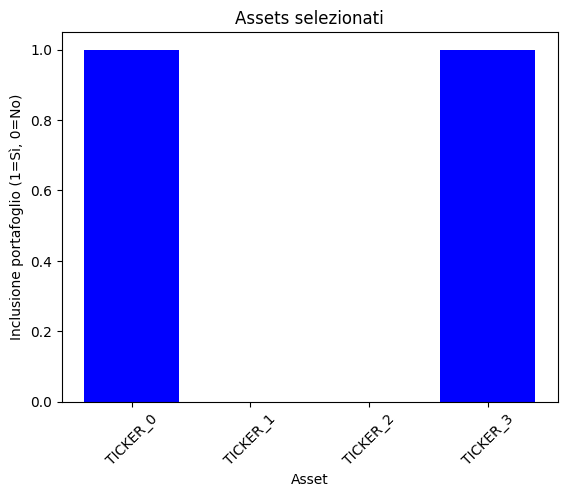

In [ ]:
selection = result.x
plt.bar(stocks, selection, color='blue')
plt.title("Assets selezionati")
plt.xlabel("Asset")
plt.ylabel("Inclusione portafoglio (1=Sì, 0=No)")
plt.xticks(rotation=45)
plt.show()

[np.float64(-0.000450676415548072), np.float64(-0.0002796194449340265), np.float64(-0.00023834473409837782), np.float64(-0.00019707002326272913), np.float64(-0.00015579531242708043), np.float64(-0.00011452060159143173), np.float64(-7.324589075578304e-05), np.float64(-3.197117992013434e-05), np.float64(9.303530915514354e-06), np.float64(5.057824175116305e-05)]


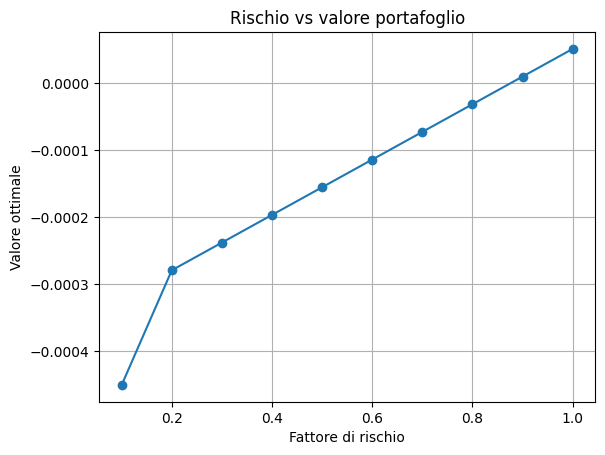

In [ ]:
risks = np.linspace(0.1, 1.0, 10)
values = []

for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values.append(result.fval)

print(values)
plt.plot(risks, values, marker='o', linestyle='-')
plt.title("Rischio vs valore portafoglio")
plt.xlabel("Fattore di rischio")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.show()


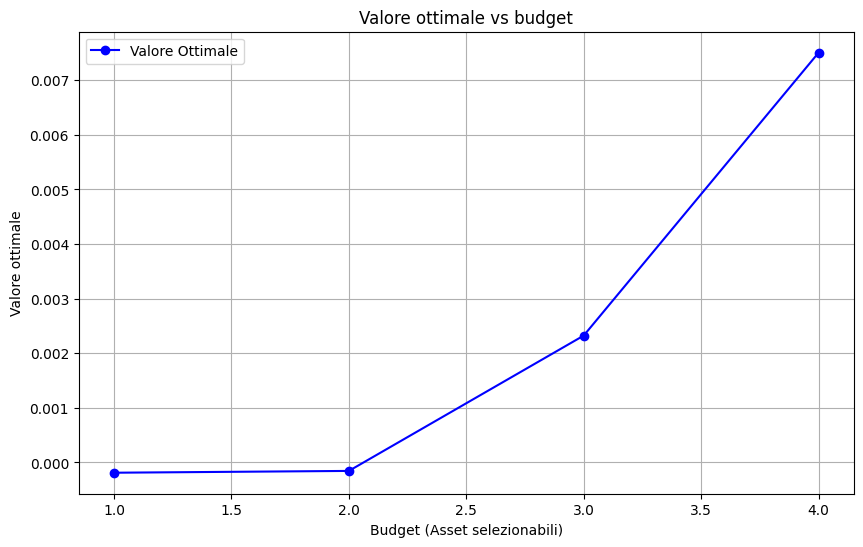

In [ ]:

budgets = range(1, assets + 1)
values_per_budget = []
risk = 0.5
selections_per_budget = []

for budget in budgets:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    
    values_per_budget.append(result.fval)
    selections_per_budget.append(result.x)

plt.figure(figsize=(10, 6))
plt.plot(budgets, values_per_budget, marker='o', linestyle='-', color='b', label='Valore Ottimale')
plt.title("Valore ottimale vs budget")
plt.xlabel("Budget (Asset selezionabili)")
plt.ylabel("Valore ottimale")
plt.grid(True)
plt.legend()
plt.show()

